# Tutorial of QA_FAST(FMRIB's Automated Segmentation Tool)

FAST (FMRIB's Automated Segmentation Tool) segments a 3D image of the brain into different tissue types (Grey Matter, White Matter, CSF, etc.), whilst also correcting for spatial intensity variations (also known as bias field or RF inhomogeneities). FAST is based on a hidden Markov random field model and an associated Expectation-Maximization algorithm. The whole process is fully automated and can also produce a bias field-corrected input image and a probabilistic and/or partial volume tissue segmentation. It is robust and reliable, compared to most finite mixture model-based methods, which are sensitive to noise.
more information about FAST, please visit https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FAST

A quality analysis picture showing the segmentation of a skull-removed brain into white matter, gray matter, and cerebrospinal fluid. Segmentation uses the function of FAST in FSL. You can use the command line below to call the FAST function in FSL for splitting. The file type is nifti image.

fast -t 1  -n 3 -o basename_for_input_skull-removed brain basename_for_outputs

## Import packages

qa_fast depends on matplotlib，numpy, nibabel, scipy and uses functions from m2g's qa_utils.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nb
from scipy import ndimage
from matplotlib.colors import LinearSegmentedColormap
from m2g.utils.qa_utils import pad_im
from m2g.stats.qa_fast import qa_fast_png

## qa_fast_png 

qa_fast_png function can overlay three image of WM, GM and csf with different color

Three slices were cut from each of the sagittal, axial, and coronal directions of the white matter, gray matter, and cerebrospinal fluid. The cut positions were 0.35, 0.51, and 0.65, respectively.

In [7]:
def qa_fast_png(csf, gm, wm, outdir):
    """
    FAST (FMRIB's Automated Segmentation Tool)
    segments a 3D image of the brain into different tissue types (Grey Matter, White Matter, CSF, etc.)
    Mark different colors of white matter, gray matter, cerebrospinal fluid in a '3 by 3' picture, i.e. QA for FAST
    
    Parameters
    ---------------
    csf: str
    the path of csf nifti image
    gm: str
    the path of gm nifti image
    wm: str
    the path of wm nifti image
    outdir: str
    the path to save QA graph
    """
    
    # load data
    gm_data = nb.load(gm).get_data()
    csf_data = nb.load(csf).get_data()
    wm_data = nb.load(wm).get_data()
    
    # set Color map
    cmap1 = LinearSegmentedColormap.from_list('mycmap1', ['white', 'blue'])
    cmap2 = LinearSegmentedColormap.from_list('mycmap2', ['white', 'magenta'])
    cmap3 = LinearSegmentedColormap.from_list('mycmap2', ['white', 'green'])
    
    
    overlay = plt.figure()
    overlay.set_size_inches(12.5, 10.5, forward=True)
    plt.title(f'Qa for FAST(segments a 3D image of the brain into different tissue types)\n (scan volume:{gm_data.shape}) \n', fontsize=22)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    
    # Determine whether the input data types are consistent. If they are inconsistent, an error is reported.
    if gm_data.shape != csf_data.shape:
        raise ValueError("GM and CSF are not the same shape.")
    elif gm_data.shape != wm_data.shape:
        raise ValueError("GM and WM are not the same shape.")
    elif wm_data.shape != csf_data.shape:
        raise ValueError("WM and CSF are not the same shape.")
    
    # Set the 3D matrix cutting position in three directions
    shape = csf_data.shape
    index = [0.35, 0.51, 0.65]
    x = [int(shape[0] * index[0]), int(shape[0] * index[1]), int(shape[0] * index[2])]
    y = [int(shape[1] * index[0]), int(shape[1] * index[1]), int(shape[1] * index[2])]
    z = [int(shape[2] * index[0]), int(shape[2] * index[1]), int(shape[2] * index[2])]
    coords = (x, y, z)
    
    # Set labels for the y-axis
    labs = [
        "Sagittal Slice",
        "Coronal Slice",
        "Axial Slice",
    ]
    
    
    var = ["X", "Y", "Z"]
    
    # Generate 3 by 3 picture
    idx = 0
    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = overlay.add_subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                csf_slice = ndimage.rotate(csf_data[pos, :, :], 90)
                gm_slice = ndimage.rotate(gm_data[pos, :, :], 90)
                wm_slice = ndimage.rotate(wm_data[pos, :, :], 90)
            elif i == 1:
                csf_slice = ndimage.rotate(csf_data[:, pos, :], 90)
                gm_slice = ndimage.rotate(gm_data[:, pos, :], 90)
                wm_slice = ndimage.rotate(wm_data[:, pos, :], 90)
            else:
                csf_slice = ndimage.rotate(csf_data[:, :, pos], 90)
                gm_slice = ndimage.rotate(gm_data[:, :, pos], 90)
                wm_slice = ndimage.rotate(wm_data[:, :, pos], 90)

            # set y labels    
            if idx % 3 == 1:
                plt.ylabel(labs[i])
            
            #  padding pictures to make them the same size
            csf_slice = (csf_slice*255).astype(np.uint8)
            gm_slice = (gm_slice*255).astype(np.uint8)
            wm_slice = (wm_slice*255).astype(np.uint8)
            csf_slice = pad_im(csf_slice, max(shape), 0, False)
            gm_slice = pad_im(gm_slice, max(shape), 0, False)
            wm_slice = pad_im(wm_slice, max(shape), 0, False)
            
            # hide axes
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            
            # display image
            ax.imshow(csf_slice, interpolation="none", cmap=cmap1, alpha=1)
            ax.imshow(gm_slice, interpolation="none", cmap=cmap2, alpha=0.5)
            ax.imshow(wm_slice, interpolation="none", cmap=cmap3, alpha=0.3)
           
            # Legend of white matter(WM), gray matter(GM) and cerebrospinal fluid(csf)
            if idx == 3:
                plt.plot(0, 0, "-", c='green', label='wm')
                plt.plot(0, 0, "-", c='pink', label='gm')
                plt.plot(0, 0, "-", c='blue', label='csf')
                plt.legend(loc='upper right',fontsize=15,bbox_to_anchor=(1.5,1.2))
                
    # save figure
    overlay.savefig(f"{outdir}", format="png")


## Set the input data path

output_dir is a path of m2g output

csf_input, gm_input, wm_input is the path of nifiti image of csf, gm and wm, respectively.

the name of the qa picture is qa_fast.png

In [3]:
# change this path to your own m2g output_dir when you want to run in your own computer
output_dir = 'd:/Downloads/neurodatadesign/output_data/flirt/sub-0025864/ses-1/'

# The following input path will be generated automatically
csf_input = f"{output_dir}anat/preproc/t1w_seg_pve_0.nii.gz"
gm_input = f"{output_dir}anat/preproc/t1w_seg_pve_1.nii.gz"
wm_input = f"{output_dir}anat/preproc/t1w_seg_pve_2.nii.gz"

# The path where the picture is saved, the name is qa_fast.png
save_dir = f"{output_dir}qa/reg/qa_fast.png"

## Call function to generate quality analysis picture

The green part of the picture shows white matter, the red part shows gray matter, and the blue part shows cerebrospinal fluid.
The number on each small picture represents the position of the slice, and the vertical axis on the left shows the orientation of the slice.

you can import qa_fast_png use 'from m2g.stats.qa_fast import qa_fast_png.
or you can also use the qa_fast_png in this tutorial

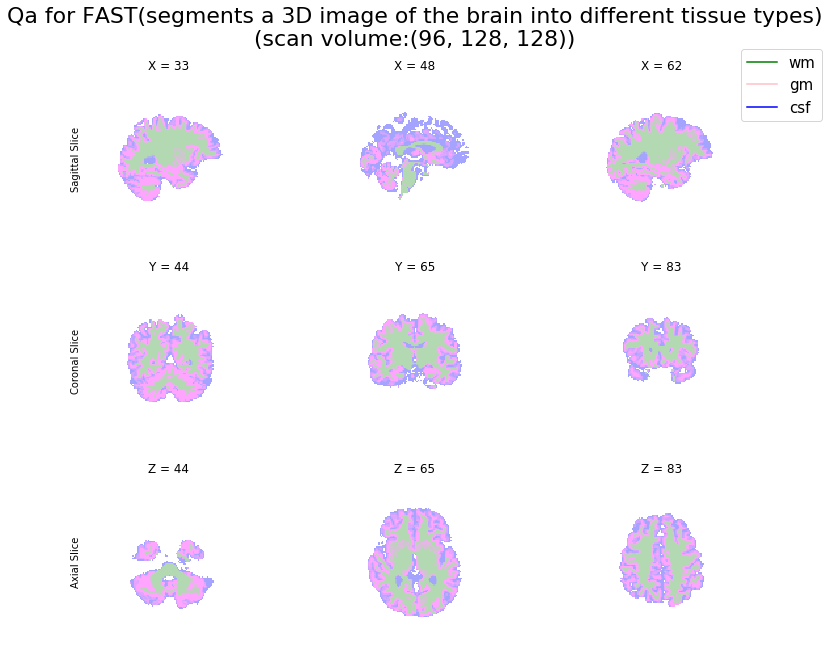

In [8]:
# Generates quality analysis pictures of white matter, gray matter and cerebrospinal fluid
qa_fast_png(csf_input, gm_input, wm_input, save_dir)

## Potential Issues

If you see the colors for the various sections of the brain are incorrect (white matter is pink or blue) check the order of the inputs for qa_fast_png. The order determines the color-scheme used for each tissue type. 

The color contrast of white matter, gray matter and cerebrospinal fluid can be adjusted by parameters in the function, and the color can also be adjusted.

Change the alpha(0-1) parameter to adjust the color depth

In [ ]:
ax.imshow(csf_slice, interpolation="none", cmap=cmap1, alpha=1)

ax.imshow(gm_slice, interpolation="none", cmap=cmap2, alpha=0.5)

ax.imshow(wm_slice, interpolation="none", cmap=cmap3, alpha=0.3)

the last parameter can change color

In [ ]:
cmap1 = LinearSegmentedColormap.from_list('mycmap1', ['white', 'blue'])

cmap2 = LinearSegmentedColormap.from_list('mycmap2', ['white', 'magenta'])

cmap3 = LinearSegmentedColormap.from_list('mycmap2', ['white', 'green'])